In [1]:
install.packages("vars")

Installing package into 'C:/Users/Natty/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

also installing the dependencies 'zoo', 'strucchange', 'urca', 'lmtest', 'sandwich'




package 'zoo' successfully unpacked and MD5 sums checked
package 'strucchange' successfully unpacked and MD5 sums checked
package 'urca' successfully unpacked and MD5 sums checked
package 'lmtest' successfully unpacked and MD5 sums checked
package 'sandwich' successfully unpacked and MD5 sums checked
package 'vars' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Natty\AppData\Local\Temp\RtmpoHWMzD\downloaded_packages


In [2]:
library("vars")

Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest



In [3]:
data(Canada)

In [5]:
summary(Canada)

       e              prod             rw              U         
 Min.   :928.6   Min.   :401.3   Min.   :386.1   Min.   : 6.700  
 1st Qu.:935.4   1st Qu.:404.8   1st Qu.:423.9   1st Qu.: 7.782  
 Median :946.0   Median :406.5   Median :444.4   Median : 9.450  
 Mean   :944.3   Mean   :407.8   Mean   :440.8   Mean   : 9.321  
 3rd Qu.:950.0   3rd Qu.:410.7   3rd Qu.:461.1   3rd Qu.:10.607  
 Max.   :961.8   Max.   :418.0   Max.   :470.0   Max.   :12.770  

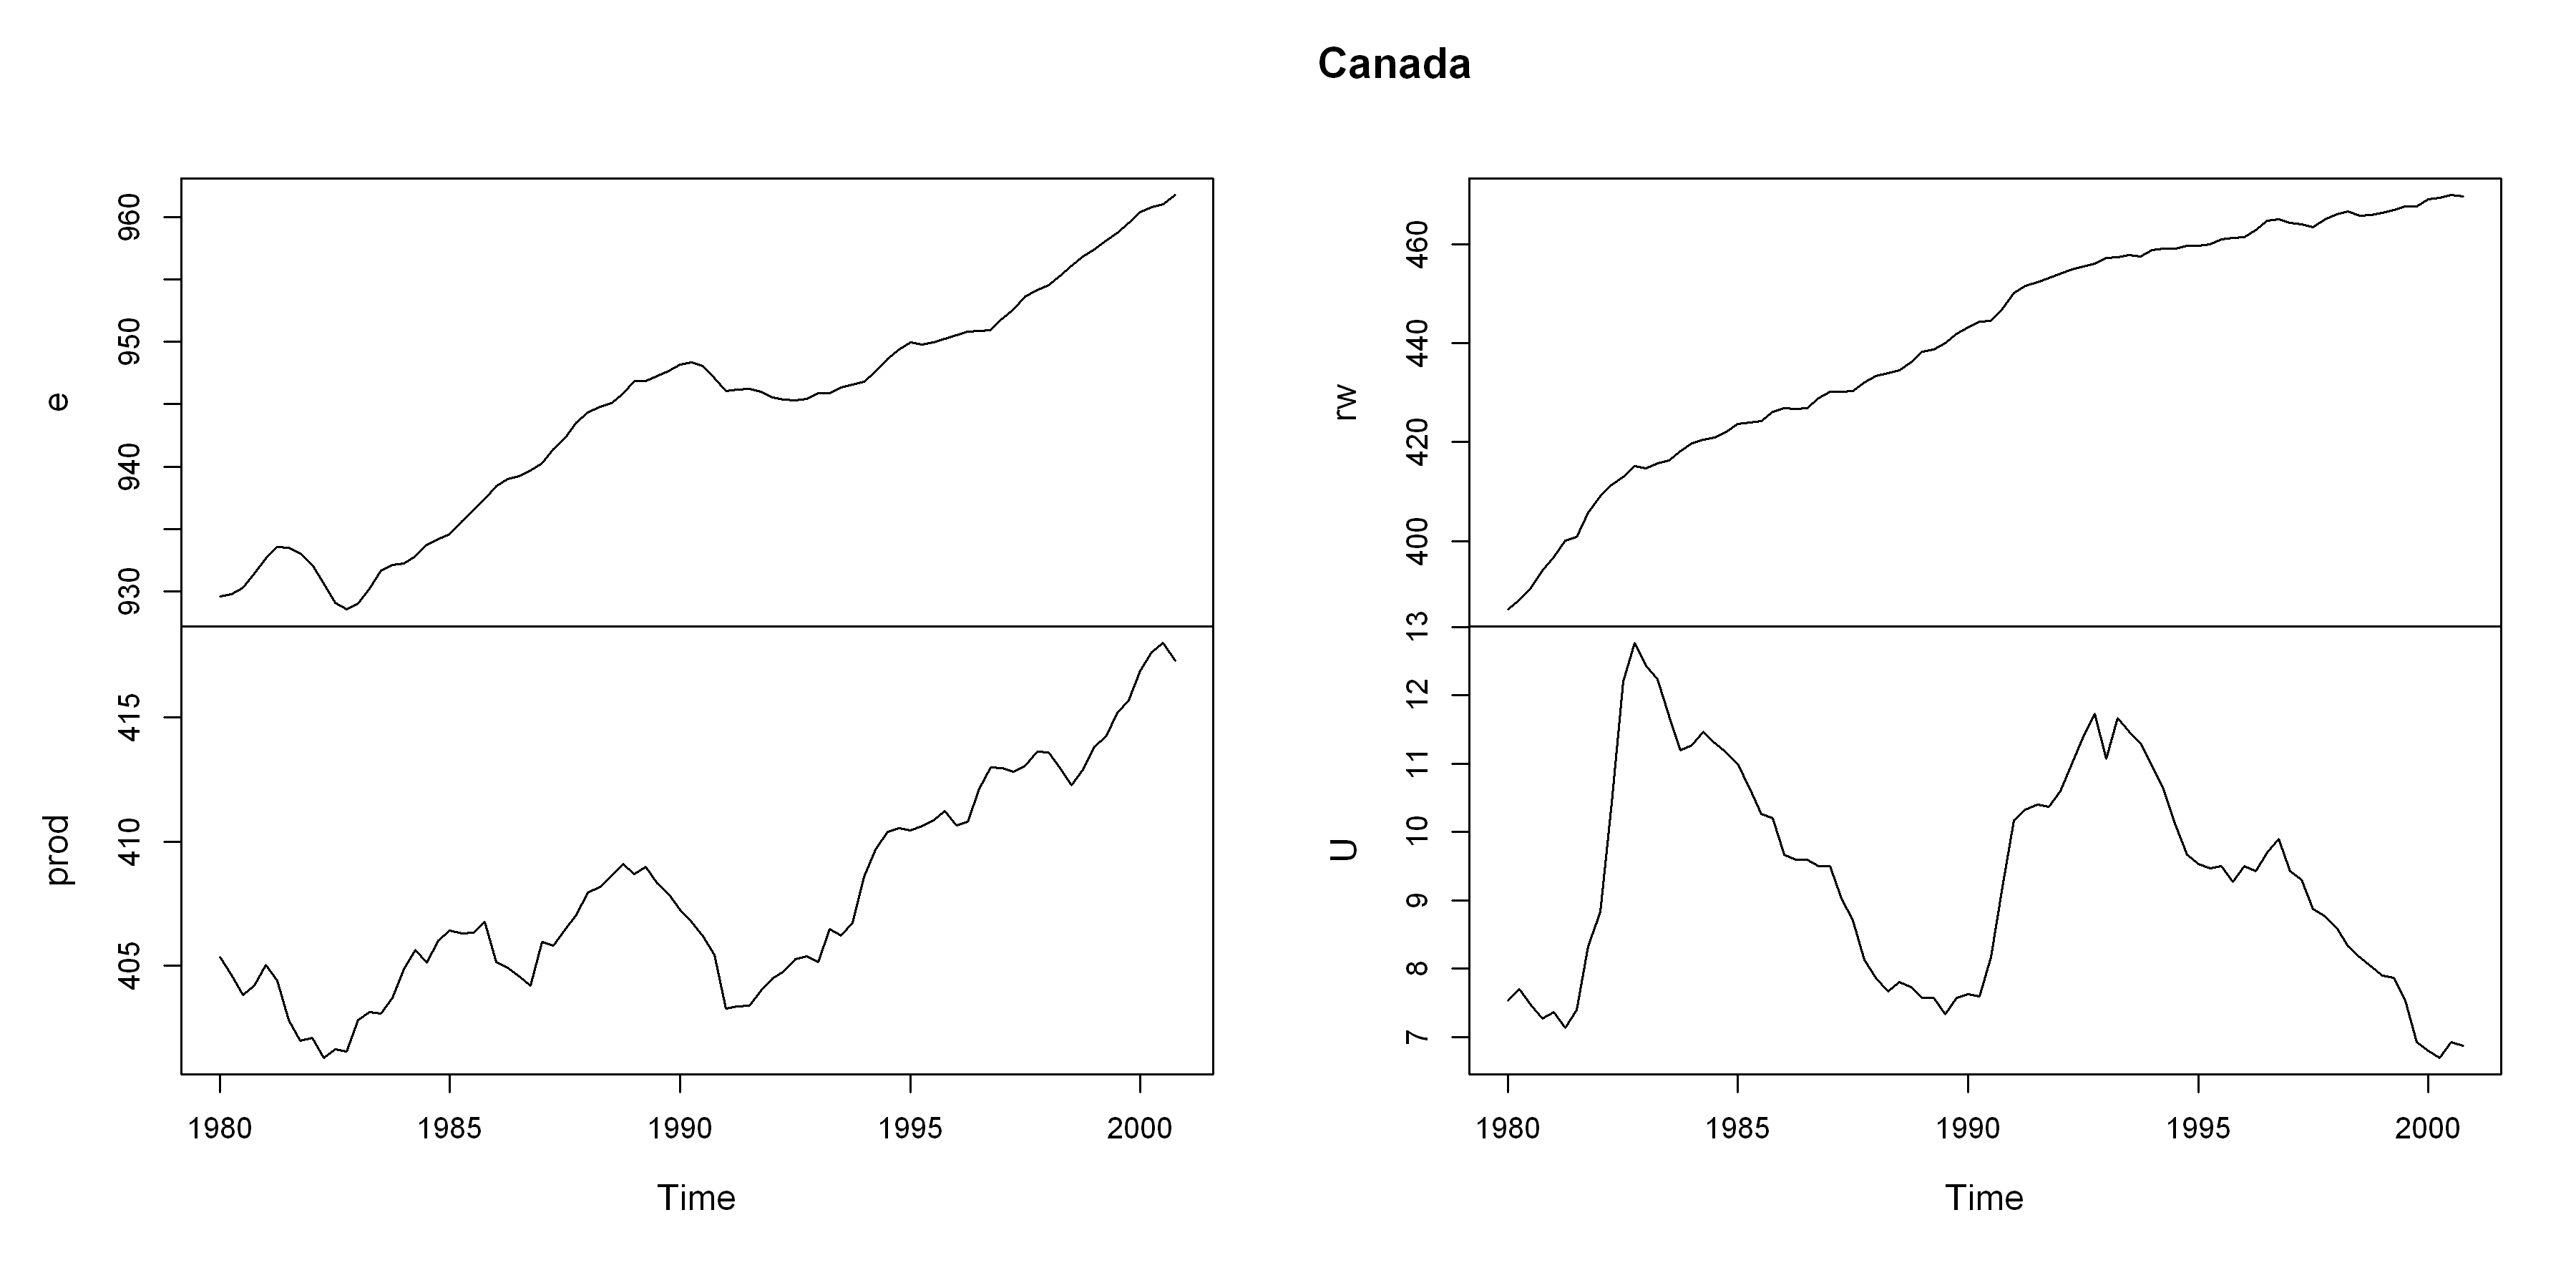

In [8]:
plot(Canada, nc=2)

In [12]:
summary(ur.df(Canada[,c("prod")], type="trend"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.22554 -0.40892  0.02578  0.41669  1.70908 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 29.281115  14.506222   2.019  0.04697 * 
z.lag.1     -0.073036   0.036127  -2.022  0.04664 * 
tt           0.014219   0.006151   2.312  0.02344 * 
z.diff.lag   0.310251   0.109678   2.829  0.00594 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6797 on 78 degrees of freedom
Multiple R-squared:  0.1467,	Adjusted R-squared:  0.1139 
F-statistic: 4.471 on 3 and 78 DF,  p-value: 0.005977


Value of test-statistic is: -2.0216 2.4483 2.6786 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.15
phi2  6.

In [15]:
summary(ur.df(Canada[,c("prod")], type = "trend", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.22554 -0.40892  0.02578  0.41669  1.70908 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 29.281115  14.506222   2.019  0.04697 * 
z.lag.1     -0.073036   0.036127  -2.022  0.04664 * 
tt           0.014219   0.006151   2.312  0.02344 * 
z.diff.lag   0.310251   0.109678   2.829  0.00594 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6797 on 78 degrees of freedom
Multiple R-squared:  0.1467,	Adjusted R-squared:  0.1139 
F-statistic: 4.471 on 3 and 78 DF,  p-value: 0.005977


Value of test-statistic is: -2.0216 2.4483 2.6786 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.15
phi2  6.

In [25]:
library(xtable)

In [31]:
help(ca.jo)

ca.jo {urca},R Documentation
x,Data matrix to be investigated for cointegration.
type,"The test to be conducted, either ‘eigen’ or ‘trace’."
ecdet,"Character, ‘none’ for no intercept in cointegration, ‘const’ for constant term in cointegration and ‘trend’ for trend variable in cointegration."
K,The lag order of the series (levels) in the VAR.
spec,"Determines the specification of the VECM, see details below."
season,"If seasonal dummies should be included, the data frequency must be set accordingly, i.e ‘4’ for quarterly data."
dumvar,"If dummy variables should be included, a matrix with row dimension equal to x can be provided."


In [19]:
VARselect(Canada, lag.max=8, type="both")

,1,2,3,4,5,6,7,8
AIC(n),-6.272579064,-6.636669705,-6.771176872,-6.634609210,-6.398132246,-6.307704843,-6.070727259,-6.06159685
HQ(n),-5.978429449,-6.146420347,-6.084827770,-5.752160366,-5.319583658,-5.033056512,-4.599979185,-4.39474903
SC(n),-5.536558009,-5.409967947,-5.053794411,-4.426546046,-3.699388378,-3.118280272,-2.390621985,-1.89081087
FPE(n),0.001889842,0.001319462,0.001166019,0.001363175,0.001782055,0.002044202,0.002768551,0.00306012


In [33]:
summary(ca.jo(Canada, type="eigen", ecdet=, K=3, spec="longrun"))


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.4178095905 0.1828654499 0.1239725051 0.0007523871

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  0.06  6.50  8.18 11.65
r <= 2 | 10.72 12.91 14.90 19.19
r <= 1 | 16.36 18.90 21.07 25.75
r = 0  | 43.82 24.78 27.14 32.14

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              e.l3    prod.l3      rw.l3       U.l3
e.l3     1.0000000  1.0000000  1.0000000  1.0000000
prod.l3  0.6409112  0.2993240 -0.5765703 -0.1674879
rw.l3   -0.6996053 -0.3775646 -0.3098725 -0.3210560
U.l3     0.5506937  2.7029914  1.7800952  1.5046076

Weights W:
(This is the loading matrix)

              e.l3    prod.l3       rw.l3         U.l3
e.d    0.025577740  0.1542901 -0.01923271 -0.004492451
prod.d 0.001322905  0.1470512  0.08043698  0.015693650
rw

In [24]:
summary(ca.jo(Canada, type="eigen", ecdet=, K=3, spec="transitory"))


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.4178095905 0.1828654499 0.1239725052 0.0007523871

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  0.06  6.50  8.18 11.65
r <= 2 | 10.72 12.91 14.90 19.19
r <= 1 | 16.36 18.90 21.07 25.75
r = 0  | 43.82 24.78 27.14 32.14

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              e.l1    prod.l1      rw.l1       U.l1
e.l1     1.0000000  1.0000000  1.0000000  1.0000000
prod.l1  0.6409112  0.2993240 -0.5765703 -0.1674879
rw.l1   -0.6996053 -0.3775646 -0.3098725 -0.3210560
U.l1     0.5506937  2.7029914  1.7800952  1.5046076

Weights W:
(This is the loading matrix)

              e.l1    prod.l1       rw.l1         U.l1
e.d    0.025577740  0.1542901 -0.01923271 -0.004492451
prod.d 0.001322905  0.1470512  0.08043698  0.015693650
rw

In [ ]:
ca.jo(x, type = c("eigen", "trace"), ecdet = c("none", "const", "trend"), K = 2,
spec=c("longrun", "transitory"), season = NULL, dumvar = NULL)

In [36]:
x <- ca.jo(Canada, type="eigen", ecdet=, K=3, spec="transitory")

In [58]:
# library(AER)
# library(dynlm)
# library(forecast)
# library(readxl)
# library(stargazer)
# library(scales)
# library(quantmod)
# library(urca)